In [2]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process


def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """

    Parameters
    ----------
    dt :
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float
        Initial values in three dimensional space
    sigma, rho, beta : float
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """
    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        """
        Fit the model with `spiketrains` data and apply the dimensionality
        reduction on `spiketrains`.

        Parameters
        ----------
        point_of_interest : tuple
            Tupel containing coordinates (x,y,z) in three dimensional space.
        timepoint : a point of interest in time
        dt :
            Integration time step in ms.
        num_steps : int
            Number of integration steps -> max_time = dt*(num_steps-1).
        sigma, rho, beta : float
            Parameters defining the lorenz attractor
        tau : characteristic timescale in ms

        Returns
        -------
        x_dot, y_dot, z_dot : float
            Values of the lorenz attractor's partial derivatives
            at the point x, y, z.
        """

        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"

    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

In [3]:
# set parameters for the integration of the Lorentz attractor
timestep = 1 * pq.ms
transient_duration = 10 * pq.s
trial_duration = 30 * pq.s
num_steps_transient = int((transient_duration.rescale('ms')/timestep).magnitude)
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data
num_trials = 100
num_spiketrains = 50

# calculate the oscillator
times, lorentz_trajectory_3dim = integrated_lorenz(
    timestep, num_steps=num_steps_transient+num_steps, x0=0, y0=1, z0=1.25)
times = (times - transient_duration).rescale('s').magnitude
times_trial = times[num_steps_transient:]

# random projection
lorentz_trajectory_Ndim = random_projection(
    lorentz_trajectory_3dim[:, num_steps_transient:], embedding_dimension=num_spiketrains)

# calculate instantaneous rate
normed_traj = lorentz_trajectory_Ndim / lorentz_trajectory_Ndim.max()
instantaneous_rates_lorentz = np.power(max_rate.magnitude, normed_traj)

# generate spiketrains
spiketrains_lorentz = generate_spiketrains(
    instantaneous_rates_lorentz, num_trials, timestep)

# Lorenz data and GPFA Trajectory extraction

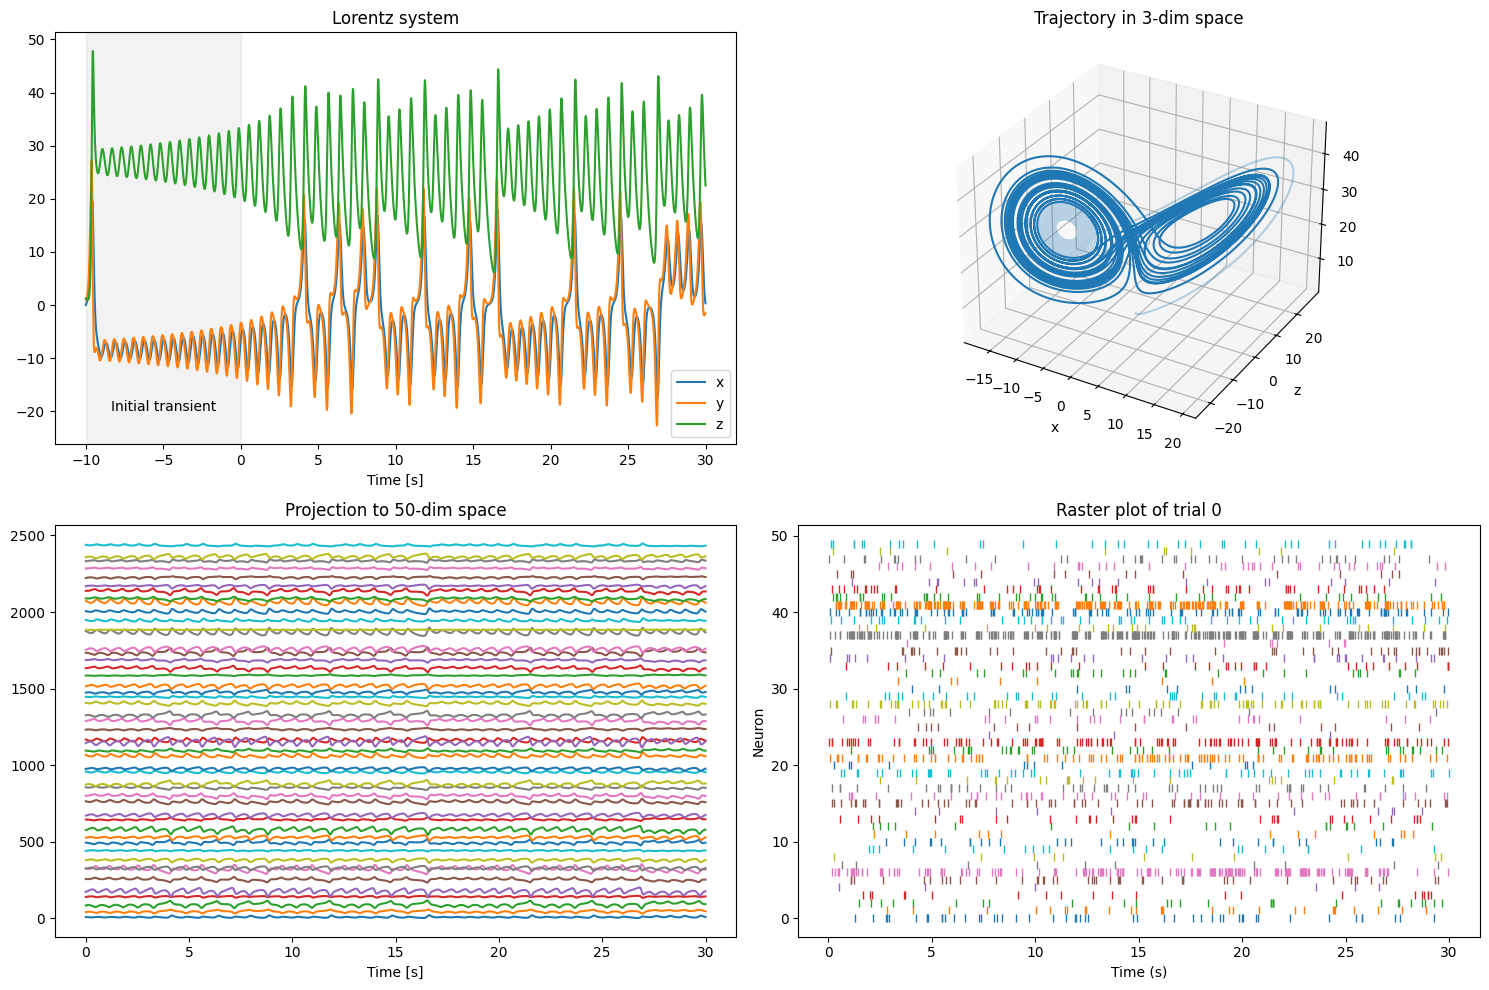

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2, projection='3d')
ax3 = f.add_subplot(2, 2, 3)
ax4 = f.add_subplot(2, 2, 4)

ax1.set_title('Lorentz system')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim):
    ax1.plot(times, x, label=labels[i])
ax1.axvspan(-transient_duration.rescale('s').magnitude, 0, color='gray', alpha=0.1)
ax1.text(-5, -20, 'Initial transient', ha='center')
ax1.legend()

ax2.set_title(f'Trajectory in 3-dim space')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_ylabel('z')
ax2.plot(lorentz_trajectory_3dim[0, :num_steps_transient],
         lorentz_trajectory_3dim[1, :num_steps_transient],
         lorentz_trajectory_3dim[2, :num_steps_transient], c='C0', alpha=0.3)
ax2.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:], c='C0')

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('Time [s]')
y_offset = lorentz_trajectory_Ndim.std() * 3
for i, y in enumerate(lorentz_trajectory_Ndim):
    ax3.plot(times_trial, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Neuron')
for i, spiketrain in enumerate(spiketrains_lorentz[trial_to_plot]):
    ax4.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [13]:
bin_size = 20 * pq.ms
latent_dimensionality = 3

from elephant.gpfa import GPFA

gpfa_3dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = gpfa_3dim.fit_transform(spiketrains_lorentz)

Initializing parameters using factor analysis...

Fitting GPFA model...


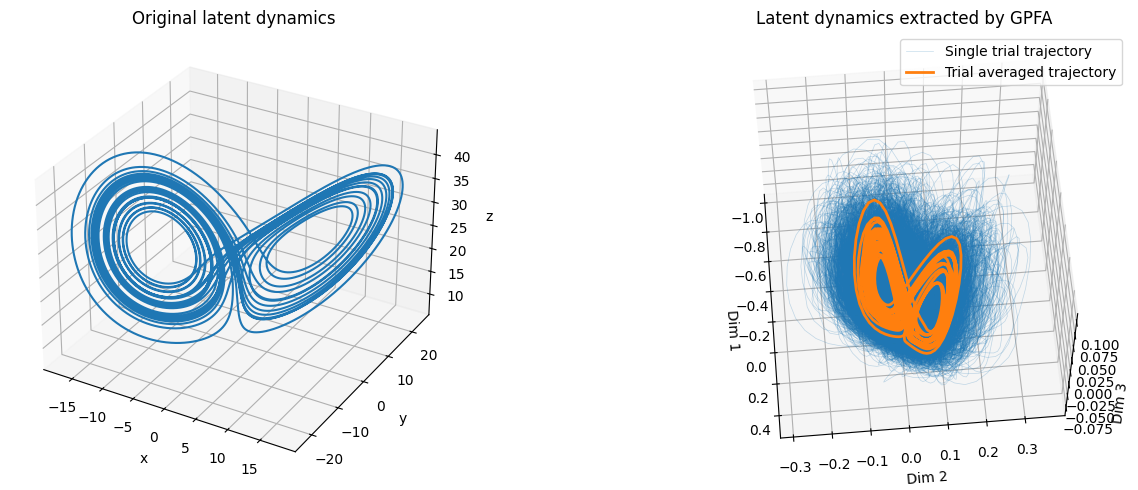

In [16]:
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.25

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
# single trial trajectories
for single_trial_trajectory in trajectories:
    l1, = ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2],
             lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial,label = 'Single trial trajectory')
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
avg, = ax2.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
plt.legend(handles=[l1,avg])
ax2.view_init(azim=-5, elev=60)  # an optimal viewing angle for the trajectory extracted from our fixed spike trains

plt.tight_layout()
plt.show()

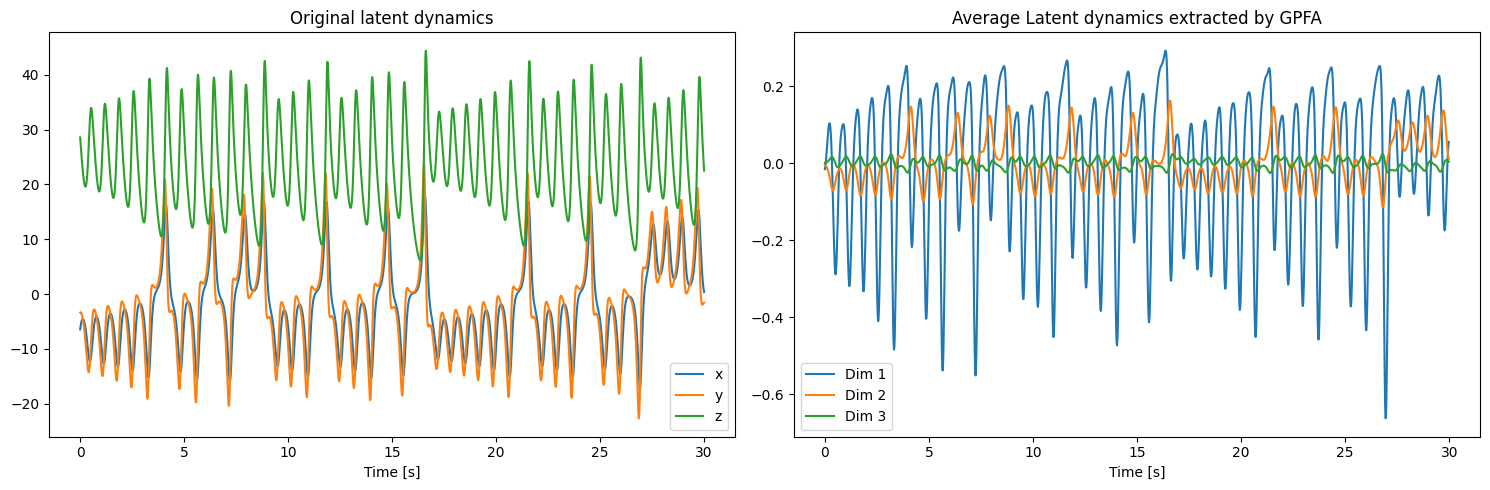

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim[:, num_steps_transient:]):
    ax1.plot(times_trial, x, label=labels[i])
ax1.legend()

ax2.set_title('Average Latent dynamics extracted by GPFA')
ax2.set_xlabel('Time [s]')
for i, x in enumerate(average_trajectory):
    ax2.plot(np.arange(len(x))*0.02, x, label=f'Dim {i+1}')
ax2.legend()

plt.tight_layout()
plt.show()

# Fit vine to lorenz data

In [18]:
import copulagp
from copulagp import vine as v
from copulagp import train

def NormalizeData(data):
    return ((data - np.min(data)) / (np.max(data) - np.min(data)))*0.9+0.01

def DenormalizeData(data,min,max):
    return ((data-0.01)/0.9)*(max-min)+min

In [59]:
trajectories.shape

(100,)

In [60]:
trajectories_concat = np.concatenate(trajectories[:100], axis=1)

In [61]:
import pickle as pkl

lorenz_min = trajectories_concat.min()
lorenz_max = trajectories_concat.max()

trajectories_scaled = NormalizeData(trajectories_concat)
trajectories_scaled.shape

(3, 150000)

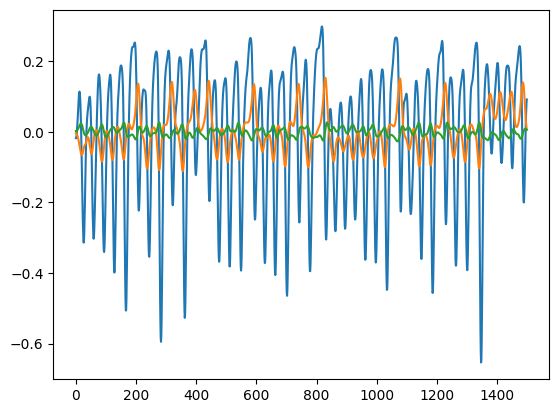

In [62]:
plt.plot(np.stack(trajectories[:20]).mean(axis=0).T)

In [63]:

with open(f'../data/lorenz_vine_data_{0}.pkl','wb') as f:
    data = dict()
    data['Y'] = trajectories_scaled.T
    data['X'] = np.concatenate([np.arange(0,1,1/trajectories[0].shape[1]) for i in range(100)])
    pkl.dump(data, f)

In [64]:
import pickle as pkl
with open(f'../data/lorenz_vine_data_{0}.pkl','rb') as f:
    data= pkl.load(f)
data['X'].shape

(150000,)

In [65]:
from copulagp.train import train_vine

train_vine(
    path_data=lambda x: f'../data/lorenz_vine_data_{x}.pkl', 
    path_models=lambda x: f'./notebook1_2/layer_{x}.pkl', 
    path_final='./notebook1_2/results/res.pkl', 
    path_logs=lambda a,b: './logs/notebook1_2_cop/', 
    exp='Vine on Lorenz Attractor',
    gauss=True
    )

Starting Vine on Lorenz Attractor layer 0/2
Error:[Errno 17] File exists: './logs/notebook1_2_cop/'
0-1 Gaussian -0.5946 took 6 min
0-2 Gaussian -0.6216 took 4 min
Layer 0 completed
Starting Vine on Lorenz Attractor layer 1/2
Error:[Errno 17] File exists: './logs/notebook1_2_cop/'
1-2 Gaussian -0.9958 took 6 min
Layer 1 completed


{'models': [[<copulagp.bvcopula.models.Pair_CopulaGP_data at 0x28802c1d0>,
 'waics': [[-0.5945716500282288, -0.6215989589691162], [-0.9957642555236816]]}

In [4]:
import pickle as pkl

with open('./notebook1_2/results/res.pkl','rb') as f:
    results_dict = pkl.load(f)

results_dict['models']

[[<copulagp.bvcopula.models.Pair_CopulaGP_data at 0x16b566850>,

In [5]:
data['Y'].mean()

NameError: name 'data' is not defined

Text(0.5, 1.08, 'Low Level Copula: Trajectories 1,2 unconditioned')

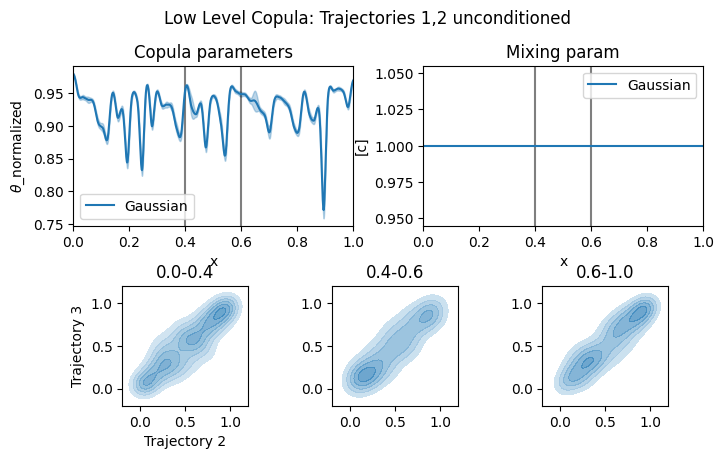

In [6]:
from copulagp.utils import Plot_Fit
import torch
import matplotlib.pyplot as plt

try:
    Plot_Fit(
        results_dict['models'][0][1].model_init(torch.device('cpu')),
        np.arange(0,1,0.001),
        results_dict['Y'].T[:100],
        'Trajectory 2',
        'Trajectory 3',
        torch.device('cpu')
        )
except TypeError:
    pass
except IndexError:
    pass
plt.suptitle('Low Level Copula: Trajectories 1,2 unconditioned',y=1.08)

Text(0.5, 1.08, 'Low Level Copula: Trajectories 1,3 unconditioned')

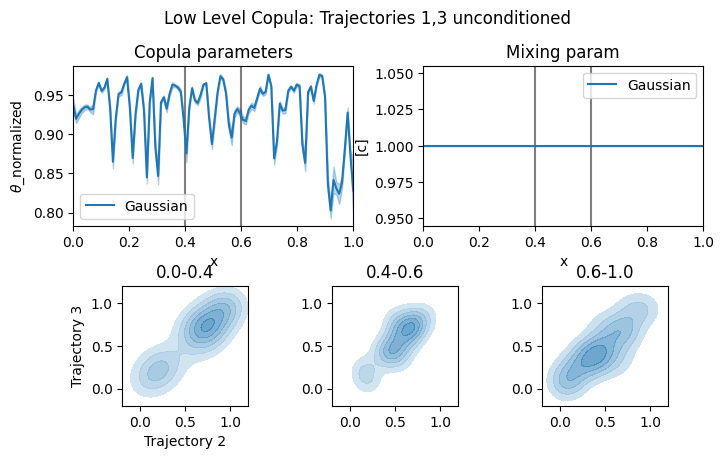

In [14]:
from copulagp.utils import Plot_Fit
import torch

try:
    Plot_Fit(
        results_dict['models'][1][0].model_init(torch.device('cpu')),
        np.arange(0,1,0.01),
        results_dict['X'].T[:100],
        'Trajectory 2',
        'Trajectory 3',
        torch.device('cpu')
        )
except TypeError:
    pass
except IndexError:
    pass
plt.suptitle('Low Level Copula: Trajectories 1,3 unconditioned',y=1.08)

In [8]:
with open(f'../data/lorenz_vine_data_{0}.pkl','rb') as f:
    data = pkl.load(f)

In [9]:
data

{'Y': array([[0.6990139 , 0.63351546, 0.63246272],
        [0.68939146, 0.63159813, 0.63262587],
        [0.67782663, 0.62884879, 0.63233061],
        ...,
        [0.79114632, 0.61866486, 0.63281622],
        [0.79098604, 0.61328592, 0.63165036],
        [0.78129604, 0.61082451, 0.63061469]]),
 'X': array([0.00000000e+00, 6.66666667e-04, 1.33333333e-03, ...,
        9.98000000e-01, 9.98666667e-01, 9.99333333e-01])}

Text(0.5, 1.08, 'Low Level Copula: Trajectories 1,2 unconditioned')

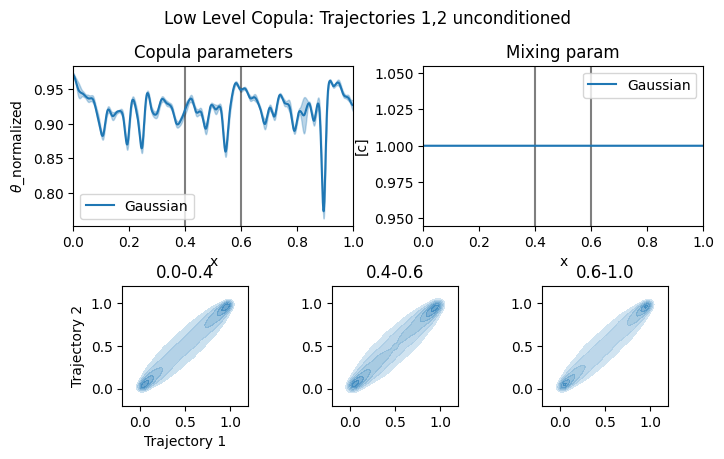

In [11]:
from copulagp.utils import Plot_Fit
import torch

try:
    Plot_Fit(
        results_dict['models'][0][0].model_init(torch.device('cpu')),
        data['X'],
        data['Y'],
        'Trajectory 1',
        'Trajectory 2',
        torch.device('cpu')
    )
except TypeError:
    pass
except IndexError:
    pass
plt.suptitle('Low Level Copula: Trajectories 1,2 unconditioned',y=1.08)

Text(0.5, 1.08, 'Low Level Copula: Trajectories 1,2 unconditioned')

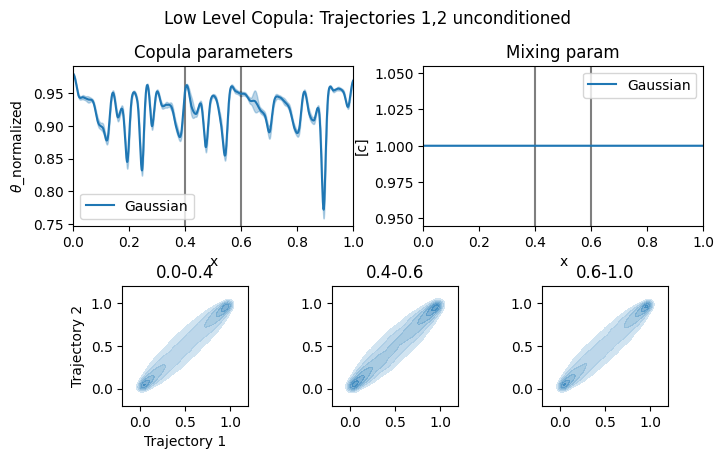

In [12]:
from copulagp.utils import Plot_Fit
import torch

try:
    Plot_Fit(
        results_dict['models'][0][1].model_init(torch.device('cpu')),
        data['X'],
        data['Y'],
        'Trajectory 1',
        'Trajectory 2',
        torch.device('cpu')
    )
except TypeError:
    pass
except IndexError:
    pass
plt.suptitle('Low Level Copula: Trajectories 1,2 unconditioned',y=1.08)

Text(0.5, 1.08, 'Low Level Copula: Trajectories 1,2 unconditioned')

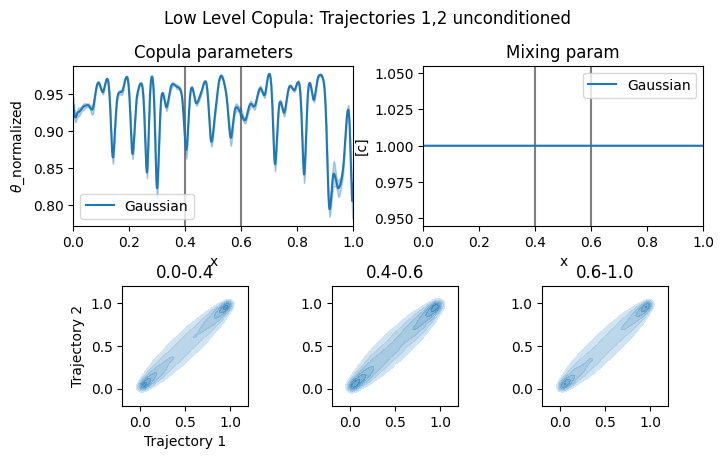

In [13]:
from copulagp.utils import Plot_Fit
import torch

try:
    Plot_Fit(
        results_dict['models'][1][0].model_init(torch.device('cpu')),
        data['X'],
        data['Y'],
        'Trajectory 1',
        'Trajectory 2',
        torch.device('cpu')
    )
except TypeError:
    pass
except IndexError:
    pass
plt.suptitle('Low Level Copula: Trajectories 1,2 unconditioned',y=1.08)

In [73]:
import torch
import copy

with open('../data/lorenz_vine_data_0.pkl','rb') as f:
    X = pkl.load(f)['X']

model_data = copy.deepcopy(results_dict['models'])
    
for i,layer in enumerate(model_data):
    for j,cop_data in enumerate(layer):
        cop = cop_data.model_init('cpu').marginalize(torch.tensor(X).double())
        model_data[i][j]=cop

In [74]:
import copulagp.vine as v
vine = v.CVine(model_data,torch.tensor(results_dict['X']).double())

In [75]:
vine.layers

[[MixtureCopula(theta: torch.Size([1, 150000]), mix: torch.Size([1, 150000])),
  MixtureCopula(theta: torch.Size([1, 150000]), mix: torch.Size([1, 150000]))],
 [MixtureCopula(theta: torch.Size([1, 150000]), mix: torch.Size([1, 150000]))]]